In [1]:
import numpy as np
import pandas as pd
import datetime
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Flatten, Dropout

In [2]:
# air_reserve = pd.read_csv('air_reserve.csv')
# air_store_info = pd.read_csv('air_store_info.csv')
air_visit_data = pd.read_csv('air_visit_data.csv')
# date_info = pd.read_csv('date_info.csv')
# hpg_reserve = pd.read_csv('hpg_reserve.csv')
# hpg_store_info = pd.read_csv('hpg_store_info.csv')
# store_id_relation = pd.read_csv('store_id_relation.csv')

In [3]:
def load(predict_day = 1, past_day = 5):
    # load data
    avd = air_visit_data.to_numpy()
    years = np.array([int(row[1].split('/')[0]) for row in avd])
    mask_2016 = years == 2016
    avd_train = avd[mask_2016]
    avd_test = avd[~mask_2016]
    
    start_time_16 = datetime.datetime.strptime('2016/1/1', '%Y/%m/%d').timestamp()
    end_time_16 = datetime.datetime.strptime('2016/12/31', '%Y/%m/%d').timestamp()
    start_time_17 = datetime.datetime.strptime('2017/1/1', '%Y/%m/%d').timestamp()
    end_time_17 = datetime.datetime.strptime('2017/12/31', '%Y/%m/%d').timestamp()
    
    for i in range(avd_train.shape[0]):
        s_date = datetime.datetime.strptime(avd_train[i, 1], '%Y/%m/%d')
        avd_train[i,1] = (s_date.timestamp() - start_time_16) / (end_time_16 - start_time_16)
    for i in range(avd_test.shape[0]):
        s_date = datetime.datetime.strptime(avd_test[i, 1], '%Y/%m/%d')
        avd_test[i,1] = (s_date.timestamp() - start_time_17) / (end_time_17 - start_time_17)
            
    X_train = []
    X_test = []
    Y_train = []
    Y_test = []
    
    for i in range(avd_train.shape[0]-predict_day-past_day):
        X_train.append(avd_train[i:i+past_day, 1])
        Y_train.append(avd_train[i+past_day:i+past_day+predict_day, 2])
    for i in range(avd_test.shape[0]-predict_day-past_day):
        X_test.append(avd_test[i:i+past_day, 1])
        Y_test.append(avd_test[i+past_day:i+past_day+predict_day, 2])
    
    xtr = tf.constant(np.array(X_train), dtype=tf.float32)
    ytr = tf.constant(np.array(Y_train), dtype=tf.int32)
    xte = tf.constant(np.array(X_test), dtype=tf.float32)
    yte = tf.constant(np.array(Y_test), dtype=tf.int32)
    
    return xtr, ytr, xte, yte

In [4]:
def rmsle(y_true, y_pred):
    return K.sqrt(K.mean(K.square(K.log(y_pred + 1) - K.log(y_true + 1)), axis=-1))

In [41]:
def build_lstm_model():
    model = Sequential()
    model.add(LSTM(16, input_shape=(5,1), return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.add(Flatten())
    model.add(Dense(5,activation='linear'))
    model.compile(loss="mean_absolute_error", optimizer="adam",metrics=[rmsle])
    model.summary()
    return model

In [6]:
# read
X_train, Y_train, X_test, Y_test = load()

In [51]:
model = build_lstm_model()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 5, 16)             1152      
                                                                 
 time_distributed_9 (TimeDis  (None, 5, 1)             17        
 tributed)                                                       
                                                                 
 flatten_9 (Flatten)         (None, 5)                 0         
                                                                 
 dense_19 (Dense)            (None, 5)                 30        
                                                                 
Total params: 1,199
Trainable params: 1,199
Non-trainable params: 0
_________________________________________________________________


In [52]:
# train model
history = model.fit(X_train, Y_train, epochs=5, batch_size = 128, validation_data=(X_test,Y_test), verbose=2)

Epoch 1/5
1364/1364 - 15s - loss: 12.9661 - rmsle: 0.8081 - val_loss: 12.1973 - val_rmsle: 0.6585 - 15s/epoch - 11ms/step
Epoch 2/5
1364/1364 - 12s - loss: 12.0495 - rmsle: 0.6443 - val_loss: 12.1842 - val_rmsle: 0.6575 - 12s/epoch - 9ms/step
Epoch 3/5
1364/1364 - 14s - loss: 12.0452 - rmsle: 0.6440 - val_loss: 12.1863 - val_rmsle: 0.6575 - 14s/epoch - 11ms/step
Epoch 4/5
1364/1364 - 17s - loss: 12.0429 - rmsle: 0.6439 - val_loss: 12.1843 - val_rmsle: 0.6574 - 17s/epoch - 13ms/step
Epoch 5/5
1364/1364 - 17s - loss: 12.0418 - rmsle: 0.6438 - val_loss: 12.1859 - val_rmsle: 0.6575 - 17s/epoch - 13ms/step


In [53]:
# predict
prediction = model.predict(X_test)

2424/2424 [==============================] - 14s 5ms/step


In [54]:
# train
loss_mean = np.mean(history.history['loss'])
rmsle_mean = np.mean(history.history['rmsle'])
print('Train Loss: {:.4f}'.format(loss_mean))
print('Train RMSLE: {:.4f}'.format(rmsle_mean))
# test
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test Loss: {:.4f}'.format(test_loss))
print('Test RMSLE: {:.4f}'.format(test_acc))

Train Loss: 12.2291
Train RMSLE: 0.6768
2424/2424 [==============================] - 14s 6ms/step - loss: 12.1859 - rmsle: 0.6575
Test Loss: 12.1859
Test RMSLE: 0.6575


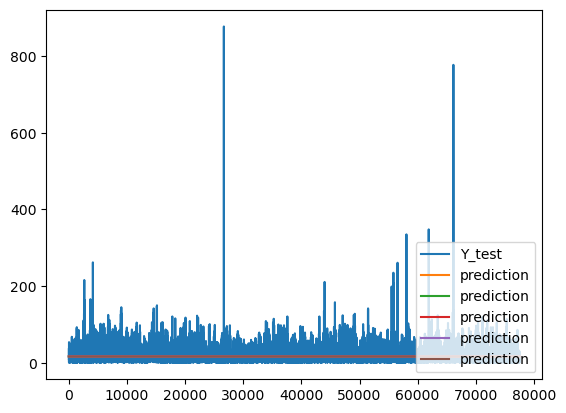

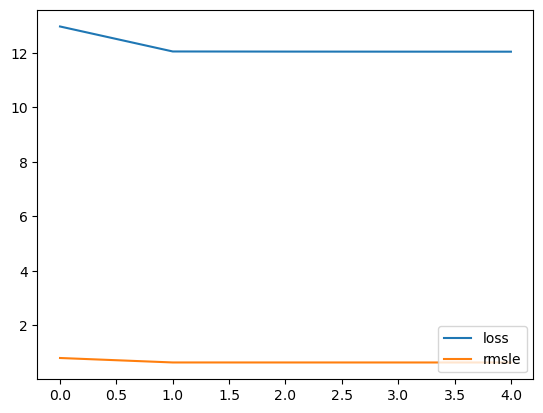

In [55]:
plt.plot(Y_test, label="Y_test")
plt.plot(prediction, label = "prediction")
plt.legend(loc='lower right')
plt.show()
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['rmsle'], label = 'rmsle')
plt.legend(loc='lower right')
plt.show()

In [18]:
for layer in model.layers:
    if hasattr(layer, 'units'):
        print(layer.units)

16
5
